In [ ]:
import datasets
from src.models.components.partmae_v3 import PARTMaskedAutoEncoderViT, PART_mae_vit_base_patch16_dec512d8b
from src.data.components.transforms.two_global_crops import ParametrizedMultiCropV1
from lightning import Fabric
from tqdm import tqdm
from torch import nn, Tensor
import torch
from torch.utils.data import Dataset, DataLoader, default_collate
from torchmetrics import MeanSquaredError, MeanMetric, MetricCollection
from PIL import Image
from lightning.fabric.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from src.callbacks.fabric.partmae_v3_metric_logger import PARTMAEv3MetricLoggerCallback
import math
import timm
import timm.scheduler
import torch.optim

## Overfit Training

In [4]:
ds = datasets.load_dataset("frgfm/imagenette", "160px", split="train")

In [5]:
class OverfitDataset(Dataset):
    def __init__(self, xs, transform=None):
        self.xs = xs
        self.transform = transform

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.xs[idx])
        return self.xs[idx]

In [ ]:
img = Image.open("../../artifacts/labrador.jpg")
imgs = [img]
V = 4
train_transform = ParametrizedMultiCropV1(n_views=V)
dataset = OverfitDataset(imgs, train_transform)
train_dataloader = DataLoader(dataset, batch_size=len(imgs), shuffle=False)

In [8]:
# overfit to a few batches
torch.set_float32_matmul_precision("medium")
logger = TensorBoardLogger("../../logs/tb_logs")
metric_logger = PARTMAEv3MetricLoggerCallback()
fabric = Fabric(precision="bf16-mixed", loggers=logger, callbacks=[metric_logger])

EPOCHS = 1
COMPILE = False

if EPOCHS < 3000:
    COMPILE = False

with fabric.init_module():
    model = PART_mae_vit_base_patch16_dec512d8b(
        sampler="stratified_jittered",
        alpha_ts=0.8,
        n_views=V,
        mask_ratio=0.75,
        pos_mask_ratio=0.75,
        alpha_t=0.75,
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=8e-6)
    # cosine scheduler
    sched = timm.scheduler.CosineLRScheduler(
        optimizer, t_initial=EPOCHS, lr_min=9e-7, warmup_t=500, warmup_lr_init=9e-7
    )

if COMPILE:
    model = torch.compile(model, fullgraph=True, dynamic=False)
model, optimizer = fabric.setup(model, optimizer)
dataloader = fabric.setup_dataloaders(train_dataloader)

pbar = tqdm(range(EPOCHS))
global_step = 0

fabric.call("on_train_start", fabric)
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    fabric.call("on_train_epoch_start", fabric, global_step, optimizer)
    for batch in dataloader:
        out = model(*batch)
        fabric.backward(out["loss"])
        optimizer.step()
        optimizer.zero_grad()

        fabric.call("on_train_batch_end", out)
        global_step += 1

    sched.step(epoch)

    # metric_logger.on_train_epoch_end(fabric, global_step)
    fabric.call("on_train_epoch_end", fabric, global_step)
    metric_dict = metric_logger.get_current_metrics()
    pbar.set_description(
        f"Loss: {metric_dict['loss']:.4f} " f"dt std: {metric_dict['dt_std'] * 512:.4f}"
    )

fabric.save(f"model_ep{EPOCHS}_V{V}.ckpt", state=model.state_dict())

Using bfloat16 Automatic Mixed Precision (AMP)
Cosine annealing scheduler will have no effect on the learning rate since t_initial = t_mul = eta_mul = 1.
Loss: 0.2928 dt std: 140.8555: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


In [9]:
EPOCHS=10000
state_dict = fabric.load(f"model_ep{EPOCHS}_V{V}.ckpt")
model.load_state_dict(state_dict)

<All keys matched successfully>

## Reconstruction

### Utils

In [11]:
def clean_model_io(batch: tuple, out: dict, device="cpu"):
    """
    Cleans and reshapes model outputs for visualization.

    - Detach and move tensors to device.
    - Reshapes ungrouped tensors (B * V ...) -> (B, V, ...).
    - Adds useful tensors to dict (patch_positions_nopos, crop_params, canonical_params)
    """
    TENSORS_TO_GROUP = [
        "patch_positions_vis",
        "ids_remove_pos",
    ]
    io = dict()

    io["img"] = batch[0]
    io["params"] = batch[1]

    B, V = io["img"].shape[:2]

    ## COMPUTE
    io["patch_positions_nopos"] = torch.gather(
        input=out["patch_positions_vis"],
        dim=1,
        index=out["ids_remove_pos"].unsqueeze(-1).expand(-1, -1, 2),
    ).unflatten(0, (B, V))

    io["crop_params"] = io["params"][:, :, 4:8]  # [B, V, 4]
    io["canonical_params"] = io["params"][:, 0, :4]  # [B, 4]
    assert torch.all(
        io["params"][:, :, :4] == io["canonical_params"].unsqueeze(1)
    ), "Canonical params are not the same for all views"

    ## GROUP AND ADD REMAINING TENSORS 
    grouped_tensors = set(out.keys()) - set(TENSORS_TO_GROUP)
    io.update({name: out[name].unflatten(0, (B, V)) for name in TENSORS_TO_GROUP})
    io.update({name: out[name] for name in grouped_tensors})

    ## MOVE TO DEVICE and DETACH
    io = {name: tensor.to(device).detach() for name, tensor in io.items()}
    return io


In [12]:
from src.utils.visualization.reconstruction_pmv3 import (
    ground_truth_reconstruction_from_crops_with_crop_params,
)

def make_plots(
    reconstructed_img: Tensor, io: dict, batch_idx: int, original_img: Image.Image
):
    patch_positions = io["patch_positions_vis"][batch_idx]  # shape: [V, N, 2]
    gt_reconstruction = ground_truth_reconstruction_from_crops_with_crop_params(
        image_crops=io["img"][batch_idx],
        patch_positions=patch_positions,
        patch_size=16,  # e.g., 16
        img_size=224,  # e.g., 224
        canonical_img_size=512,  # e.g., 512
        crop_params=io["crop_params"][batch_idx],
    )
    fig, axes = plt.subplots(1, 3)
    canonical_img = train_transform.recreate_canonical(
        original_img, io["canonical_params"][batch_idx].tolist()
    )
    axes[0].imshow(canonical_img)
    axes[0].set_title("Original")
    axes[1].imshow(gt_reconstruction.permute(1, 2, 0).cpu())
    axes[1].set_title("GT reconstruction")
    axes[2].imshow(reconstructed_img.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstruction")
    return fig, axes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


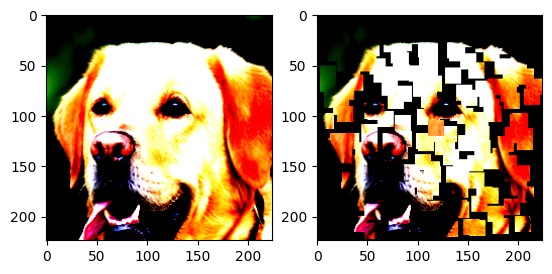

In [13]:
from src.callbacks.loggers.pretrain.reconstruction_v3 import reconstruct_image_from_model_outputs

batch = next(iter(dataloader))
model.update_conf(mask_ratio=0, pos_mask_ratio=0.1)
with torch.no_grad():
    out = model(*batch)

reconstructed_img = reconstruct_image_from_model_outputs(
    out["patch_positions_vis"][0],
    out["ids_remove_pos"][0],
    out["pred_dT"][0, 0, 0, :, :, :2].flatten(0, 1),
    batch[0][0, 0],
    model.patch_size,
)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(batch[0][0, 0].permute(1, 2, 0).cpu())
ax[1].imshow(reconstructed_img.permute(1, 2, 0).cpu())
plt.show()

In [14]:
batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75, pos_mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

In [15]:
def clean_model_io(batch: tuple, out: dict, device="cpu"):
    """
    Cleans and reshapes model outputs for visualization.

    - Detach and move tensors to device.
    - Reshapes ungrouped tensors (B * V ...) -> (B, V, ...).
    - Adds useful tensors to dict (patch_positions_nopos, crop_params, canonical_params)
    """
    TENSORS_TO_GROUP = [
        "patch_positions_vis",
        "ids_remove_pos",
    ]
    io = dict()

    io["img"] = batch[0]
    io["params"] = batch[1]

    B, V = io["img"].shape[:2]

    ## COMPUTE
    io["patch_positions_nopos"] = torch.gather(
        input=out["patch_positions_vis"],
        dim=1,
        index=out["ids_remove_pos"].unsqueeze(-1).expand(-1, -1, 2),
    ).unflatten(0, (B, V))

    io["crop_params"] = io["params"][:, :, 4:8]  # [B, V, 4]
    io["canonical_params"] = io["params"][:, 0, :4]  # [B, 4]
    assert torch.all(
        io["params"][:, :, :4] == io["canonical_params"].unsqueeze(1)
    ), "Canonical params are not the same for all views"

    ## GROUP AND ADD REMAINING TENSORS 
    grouped_tensors = set(out.keys()) - set(TENSORS_TO_GROUP)
    io.update({name: out[name].unflatten(0, (B, V)) for name in TENSORS_TO_GROUP})
    io.update({name: out[name] for name in grouped_tensors})

    ## MOVE TO DEVICE and DETACH
    io = {name: tensor.to(device).detach() for name, tensor in io.items()}
    return io


### LSTSQ (with centering)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5385373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6121132].
/tmp/ipykernel_22466/3820632241.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


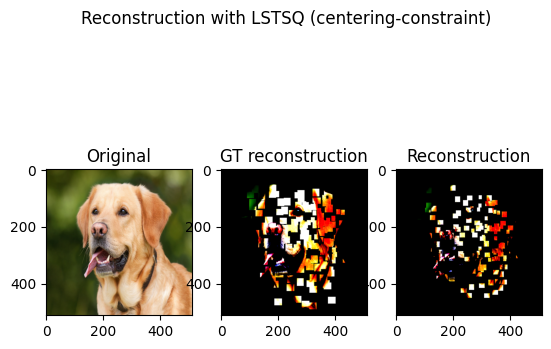

In [ ]:
%load_ext autoreload
%autoreload 2
from src.utils.visualization.reconstruction_lstq import reconstruction_lstsq

batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75, pos_mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out)

reconstructed_image = reconstruction_lstsq(
    patch_positions_nopos=io["patch_positions_nopos"][0],
    pred_dT=io["pred_dT"][0],
    original_images=io["img"][0],
    patch_size=16,  
    img_size=224,
    canonical_img_size=512,
    max_scale_ratio=4.0,
    target_scale_ratio=1.2,
)

fig, ax = make_plots(reconstructed_image, io, 0, imgs[0])
fig.suptitle("Reconstruction with LSTSQ (centering-constraint)")
fig.show()

#### plotting refined positions

5 8
torch.Size([1, 8, 8, 5, 5, 4])
torch.Size([1, 8, 8, 5, 5, 4])
torch.Size([1, 8, 8, 5, 5, 4])
torch.Size([1, 8, 8, 5, 5, 4])


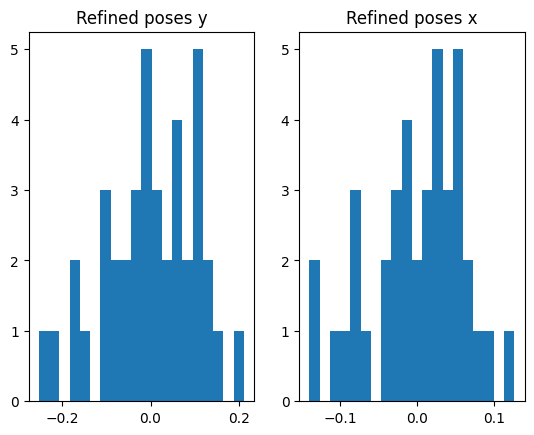

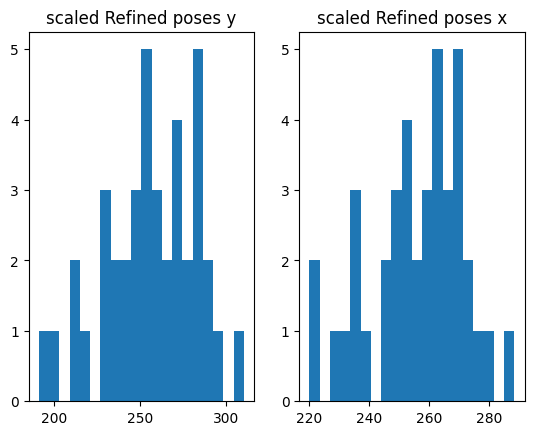

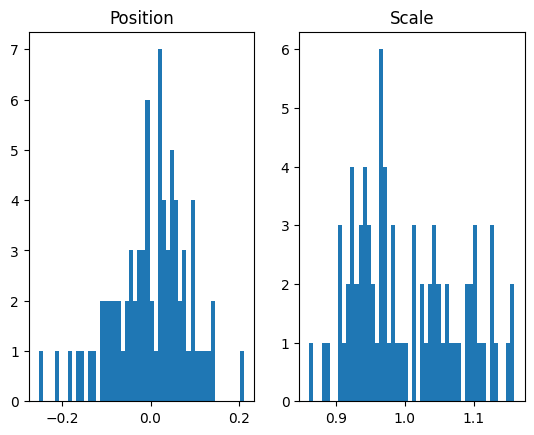

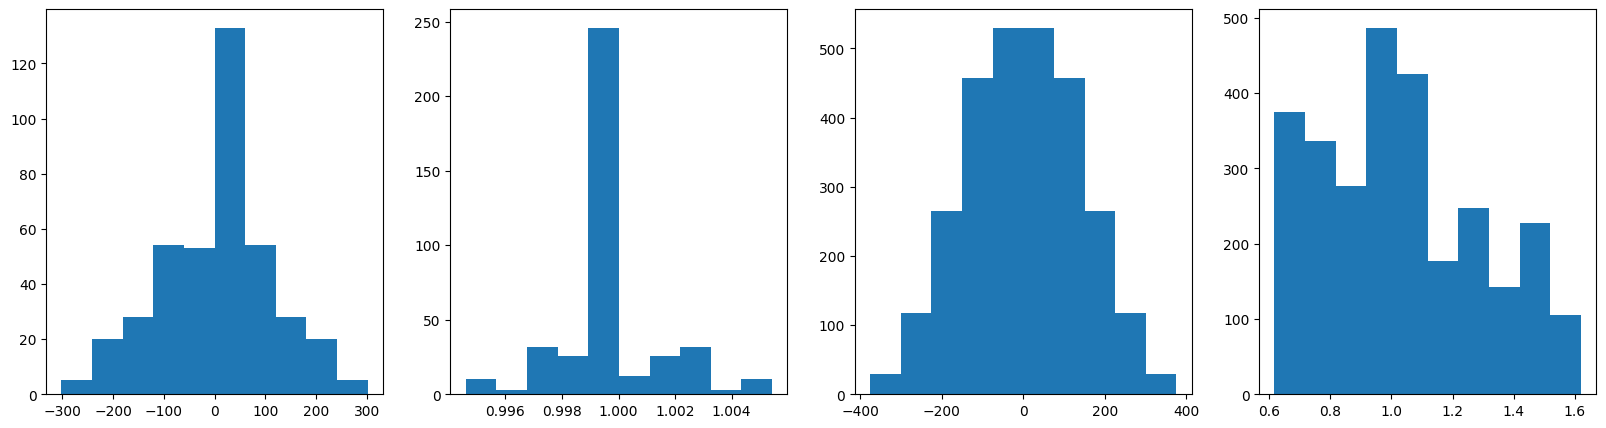

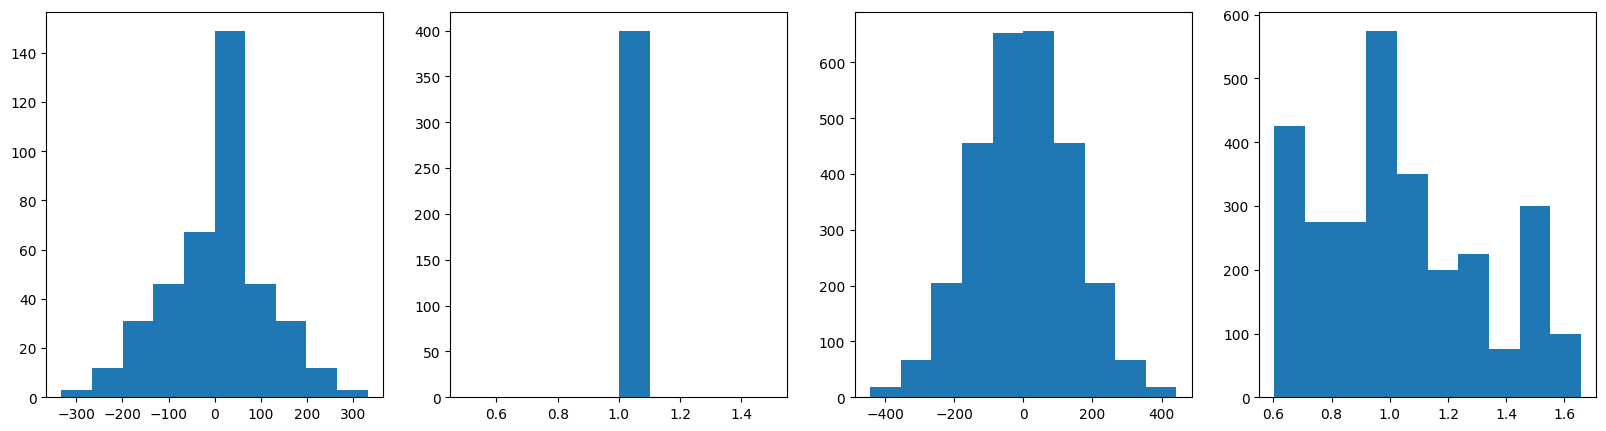

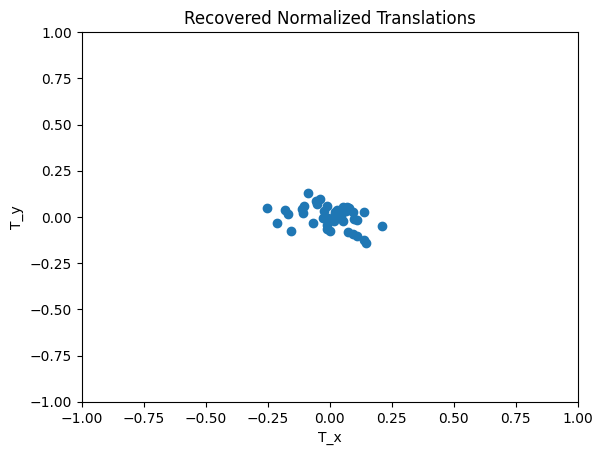

In [ ]:
N_nopos = out["ids_remove_pos"].shape[1]  # number of masked tokens per view
M = V * N_nopos # total masked tokens across views
print(N_nopos, V)


pred_dT = out["pred_dT"][0].reshape(M, M, 4).clone()
gt_dT = out["gt_dT"][0].reshape(M, M, 4).clone()
pred_dT[:, :, :2] = pred_dT[:, :, :2]
pred_dT[:, :, 2:] = pred_dT[:, :, 2:] 
# refined_poses = reconstruct_4d_poses_centered_torch_vectorized(pred_dT)
refined_poses = reconstruct_4d_poses_centered_torch_vectorized(gt_dT)
# refined_poses[:, :2] *= 512

fig, axes = plt.subplots(1, 2, squeeze=False)
axes[0][0].hist(refined_poses[:,0].flatten().cpu(), bins=20)
axes[0][0].set_title("Refined poses y")
axes[0][1].hist(refined_poses[:,1].flatten().cpu(), bins=20)
axes[0][1].set_title("Refined poses x")


fig, axes = plt.subplots(1, 2, squeeze=False)
ref = (refined_poses[:, :2] + 1 ) * (512 / 2)
axes[0][0].hist(ref[:,0].flatten().cpu(), bins=20)
axes[0][0].set_title("scaled Refined poses y")
axes[0][1].hist(ref[:,1].flatten().cpu(), bins=20)
axes[0][1].set_title("scaled Refined poses x")

fig, axes = plt.subplots(1, 2)
axes[0].hist(refined_poses[:,:2].flatten().cpu(), bins=50) # position 
axes[0].set_title("Position")

# T_norm = refined_poses[:, :2]
# refined_trans_canonical = (T_norm + 1) * (canonical_img_size / 2)
axes[1].hist(torch.exp(refined_poses[:,2:]).flatten().cpu(), bins=50)
axes[1].set_title("Scale")

diag_mask = torch.eye(V, device=fabric.device, dtype=torch.bool).view(
    1, V, V, 1, 1, 1
)  # Intra-view (diagonal)

mask = diag_mask.expand_as(out["pred_dT"])
print(out["pred_dT"].shape)
print(mask.shape)
intra_dT = out["pred_dT"][mask].view(-1, 4)
inter_dT = out["pred_dT"][~mask].view(-1, 4)
intra_dt = 512 * intra_dT[:, :2]
intra_ds = torch.exp(intra_dT[:, 2:] * math.log(4.0)) 
inter_dt = 512 * inter_dT[:, :2]
inter_ds = torch.exp(inter_dT[:, 2:] * math.log(4.0))

# plot distribution
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].hist(intra_dt.flatten().cpu())
ax[1].hist(intra_ds.flatten().cpu())
ax[2].hist(inter_dt.flatten().cpu())
ax[3].hist(inter_ds.flatten().cpu())


mask = diag_mask.expand_as(out["gt_dT"])
print(out["gt_dT"].shape)
print(mask.shape)
intra_dT = out["gt_dT"][mask].view(-1, 4)
inter_dT = out["gt_dT"][~mask].view(-1, 4)
intra_dt = 512 * intra_dT[:, :2]
intra_ds = torch.exp(intra_dT[:, 2:] * math.log(4.0)) 
inter_dt = 512 * inter_dT[:, :2]
inter_ds = torch.exp(inter_dT[:, 2:] * math.log(4.0))

# plot distribution
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].hist(intra_dt.flatten().cpu())
ax[1].hist(intra_ds.flatten().cpu())
ax[2].hist(inter_dt.flatten().cpu())
ax[3].hist(inter_ds.flatten().cpu())

T_norm = refined_poses[:, :2].detach().cpu().numpy()
fig, ax = plt.subplots(1)
ax.scatter(T_norm[:, 0], T_norm[:, 1])
# title("Recovered Normalized Translations")
ax.set_title("Recovered Normalized Translations")

ax.set_xlabel("T_x")
ax.set_ylabel("T_y")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.show()


### Global Optimization

Iteration 0/1000, T Loss: 0.18028, S Loss: 0.05184, Total: 18.07942
Iteration 100/1000, T Loss: 0.00016, S Loss: 0.00006, Total: 0.01633
Iteration 200/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576
Iteration 300/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576
Iteration 400/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576
Iteration 500/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576
Iteration 600/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576
Iteration 700/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576
Iteration 800/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1140008..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9981401..2.64].


Iteration 900/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576
Iteration 999/1000, T Loss: 0.00015, S Loss: 0.00004, Total: 0.01576
Placed 148/148 patches (100.0%)


/tmp/ipykernel_5970/2439012944.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


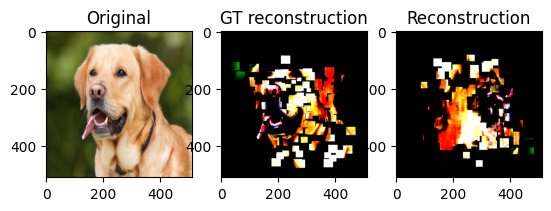

In [ ]:
from src.utils.visualization.reconstruction_pmv3 import global_optimization_reconstruction_from_crops, ground_truth_reconstruction_from_crops_with_crop_params

batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75, pos_mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out)

reconstructed_image, pos, scale = global_optimization_reconstruction_from_crops(
    image_crops=io["img"][0],
    patch_positions=io["patch_positions_nopos"][0],
    pred_dT=io["pred_dT"][0],
    patch_size=16,  # or wherever your patch size is stored
    img_size=224,
    canonical_img_size=512,
    max_scale_ratio=4.0,
    crop_params=io["crop_params"][0],
    num_iterations=1000,
    learning_rate=0.01,
    translation_weight=100,
)

fig, axes = make_plots(reconstructed_image, io, 0, imgs[0])
fig.show()

### Alternating Global Optimization

Iteration 0/10000 | Total Loss: 506814.21875 | Trans Loss: 101362.82031 | Scale Loss: 0.12369
Iteration 1000/10000 | Total Loss: 463785.28125 | Trans Loss: 92757.05469 | Scale Loss: 0.00008
Iteration 2000/10000 | Total Loss: 424310.03125 | Trans Loss: 84862.00781 | Scale Loss: 0.00008
Iteration 3000/10000 | Total Loss: 387817.84375 | Trans Loss: 77563.57031 | Scale Loss: 0.00008
Iteration 4000/10000 | Total Loss: 353944.25000 | Trans Loss: 70788.85156 | Scale Loss: 0.00008
Iteration 5000/10000 | Total Loss: 322451.81250 | Trans Loss: 64490.35938 | Scale Loss: 0.00008
Iteration 6000/10000 | Total Loss: 293174.34375 | Trans Loss: 58634.86719 | Scale Loss: 0.00008
Iteration 7000/10000 | Total Loss: 265990.43750 | Trans Loss: 53198.08594 | Scale Loss: 0.00008
Iteration 8000/10000 | Total Loss: 240797.51562 | Trans Loss: 48159.50391 | Scale Loss: 0.00008
Iteration 9000/10000 | Total Loss: 217496.40625 | Trans Loss: 43499.28125 | Scale Loss: 0.00008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5524476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3930254].


Iteration 9999/10000 | Total Loss: 196012.46875 | Trans Loss: 39202.49219 | Scale Loss: 0.00008


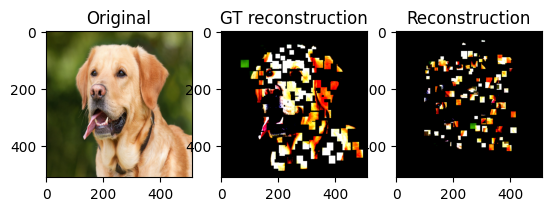

In [25]:
from src.utils.visualization.reconstruction_a2 import alternating_global_optimization_reconstruction_from_crops

batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out)

reconstructed_image = alternating_global_optimization_reconstruction_from_crops(
    image_crops=io["img"][0],
    patch_positions=io["patch_positions_nopos"][0],
    pred_dT=io["pred_dT"][0],
    patch_size=16,  # or wherever your patch size is stored
    img_size=224,
    canonical_img_size=512,
    max_scale_ratio=4.0,
    crop_params=io["crop_params"][0],
    num_iterations=10000,
)

fig, axes = make_plots(reconstructed_image, io, 0, imgs[0])

### Least squares

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.354905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0993252..2.2901711].
/tmp/ipykernel_5970/400141779.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


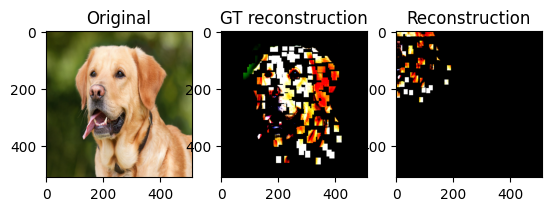

In [26]:
from src.utils.visualization.reconstruction_a2 import joint_least_squares_reconstruction_from_crops

batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out)
reconstructed_image = joint_least_squares_reconstruction_from_crops(
    image_crops=io["img"][0],
    patch_positions=io["patch_positions_nopos"][0],
    pred_dT=io["pred_dT"][0],
    patch_size=16,  # or wherever your patch size is stored
    img_size=224,
    canonical_img_size=512,
    max_scale_ratio=4.0,
    crop_params=io["crop_params"][0],
    translation_weight=100,
)
fig, axes = make_plots(reconstructed_image, io, 0, imgs[0])
fig.show()

### Alternating global optimization (normalized)

Iteration 0/200 | Total Loss: 0.05669 | T Loss: 0.06863 | S Loss: 0.00893
Iteration 20/200 | Total Loss: 0.01839 | T Loss: 0.02273 | S Loss: 0.00024
Iteration 40/200 | Total Loss: 0.00595 | T Loss: 0.00717 | S Loss: 0.00002
Iteration 60/200 | Total Loss: 0.00196 | T Loss: 0.00220 | S Loss: 0.00018
Iteration 80/200 | Total Loss: 0.00074 | T Loss: 0.00068 | S Loss: 0.00011
Iteration 100/200 | Total Loss: 0.00039 | T Loss: 0.00024 | S Loss: 0.00011


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.558999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0648172..2.5609877].


Iteration 120/200 | Total Loss: 0.00029 | T Loss: 0.00011 | S Loss: 0.00011
Iteration 140/200 | Total Loss: 0.00026 | T Loss: 0.00008 | S Loss: 0.00011
Iteration 160/200 | Total Loss: 0.00025 | T Loss: 0.00007 | S Loss: 0.00011
Iteration 180/200 | Total Loss: 0.00025 | T Loss: 0.00007 | S Loss: 0.00011
Iteration 199/200 | Total Loss: 0.00025 | T Loss: 0.00007 | S Loss: 0.00011


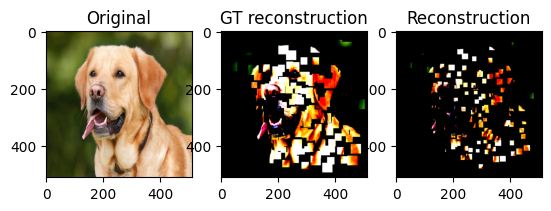

In [30]:
from src.utils.visualization.reconstruction_norm import alternating_global_optimization_reconstruction_normalized

batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75, pos_mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out)
reconstructed_image = alternating_global_optimization_reconstruction_normalized(
    image_crops=io["img"][0],
    patch_positions=io["patch_positions_nopos"][0],
    pred_dT=io["pred_dT"][0],
    patch_size=16,  # or wherever your patch size is stored
    img_size=224,
    canonical_img_size=512,
    max_scale_ratio=4.0,
    crop_params=io["crop_params"][0],
    num_iterations=200,
    lr_T=0.01,
    lr_S=0.01,
)

fig, axes = make_plots(reconstructed_image, io, 0, imgs[0])

### Least squares with anchor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1166806..2.319937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.63885..0.9014335].


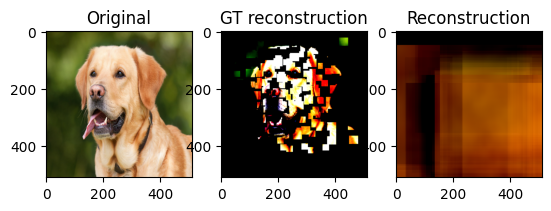

In [63]:
%load_ext autoreload
%autoreload 2
# from src.utils.visualization.reconstruction_anchor import reconstruction_from_gt_dT_with_anchor
# import src.utils.visualization.reconstruction_anchor as module
# from src.utils.visualization.reconstruction_anchor import reconstruction_from_gt_dT_with_anchor
# import importlib
from src.utils.visualization.reconstruction_anchor_v3 import reconstruction_lstsq_anchor, compute_anchor_pose
# importlib.reload(my_module)


batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75, pos_mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out)

anchor_pose = compute_anchor_pose(
    crop_params=io["crop_params"][0],
    patch_positions_nopos=io["patch_positions_nopos"][0],
    crop_size=224,
    patch_size=16,
)
reconstructed_image = reconstruction_lstsq_anchor(
    original_images=io["img"][0],
    patch_positions_nopos=io["patch_positions_nopos"][0],
    pred_dT=io["gt_dT"][0],
    patch_size=16,  # or wherever your patch size is stored
    img_size=224,
    canonical_img_size=512,
    max_scale_ratio=4.0,
    anchor_pose=anchor_pose,

)

fig, axes = make_plots(reconstructed_image, io, 0, imgs[0])



#### analysis lstq solutions

In [36]:
batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75, pos_mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

assert V == model.n_views
bix = 0
patch_positions_nopos = torch.gather(
    out["patch_positions_vis"], dim=1, index=out["ids_remove_pos"].unsqueeze(-1).expand(-1, -1, 2)
)
crop_size = 224
canonical_img_size = 512
patch_positions_nopos = patch_positions_nopos[:V].detach().cpu()
canonical_params = batch[1][bix, 0, :4].cpu()
crop_params = batch[1][bix, : , 4:].unsqueeze(1).cpu()
origin = crop_params[..., :2]  # [B, V, 1, 2]
size = crop_params[..., 2:4]  # [B, V, 1, 2]
scale = size / crop_size  # [B, V, 1, 2]
print(origin.shape, patch_positions_nopos.shape, scale.shape)
gt_patch_positions_raw = origin + patch_positions_nopos * scale
V, N, _ = gt_patch_positions_raw.shape
M = V * N
gt_patch_positions = gt_patch_positions_raw.reshape(M, 2)
print(gt_patch_positions.shape)
pose_i = gt_patch_positions.unsqueeze(0)
pose_j = gt_patch_positions.unsqueeze(1)
gt_dt_ij = pose_i - pose_j # works
gt_dt_ji = pose_j - pose_i # doesn't work


weights = torch.ones((M, M))
    
# Choose anchor: set the first patch as anchor.
anchor_index = 0
anchor_value = gt_patch_positions[0]
out_gt_dt_raw = out["gt_dT"][0, :, :, :, :, :2]
out_gt_dt = out_gt_dt_raw.permute(0, 2, 1, 3, 4).reshape(M, M, 2).cpu() * canonical_img_size
# Solve for x using the reparameterized LS solver.
T_est_ij = ls_solver_fixed_anchor_reparam(gt_dt_ij, weights, M, anchor_index, anchor_value)
T_est_ji = ls_solver_fixed_anchor_reparam(gt_dt_ji, weights, M, anchor_index, anchor_value)
T_est_gt = ls_solver_fixed_anchor_reparam(out_gt_dt, weights, M, anchor_index, anchor_value)

torch.Size([4, 1, 2]) torch.Size([4, 37, 2]) torch.Size([4, 1, 2])
torch.Size([148, 2])


In [37]:
print(torch.allclose(gt_patch_positions, T_est_ij, atol=3)) # true
print(torch.allclose(gt_patch_positions, T_est_ji, atol=3)) # false
print(torch.allclose(gt_patch_positions, T_est_gt, atol=3)) # false

True
False
False


In [ ]:
gt_patch_positions_raw.shape

torch.Size([8, 37, 2])

In [ ]:
gtpose_i = gt_patch_positions_raw.unsqueeze(0).unsqueeze(1).unsqueeze(3)
gtpose_j = gt_patch_positions_raw.unsqueeze(0).unsqueeze(2).unsqueeze(4)
gt_dT_ij_raw = gtpose_i - gtpose_j
print(gt_dT_ij_raw.shape)
gt_dT_ij = gt_dT_ij_raw[0].permute(0, 2, 1, 3, 4).reshape(M, M, 2)
T = ls_solver_fixed_anchor_reparam(gt_dT_ij, weights, M, anchor_index, anchor_value)
print(torch.allclose(gt_patch_positions, T, atol=3))  # true

torch.Size([1, 8, 8, 37, 37, 2])
True


In [ ]:
out_gt_dt_raw = out["gt_dT"][0, :, :, :, :, :2].cpu() * 512
torch.allclose(gt_dT_ij_raw[0], out_gt_dt_raw, atol=3)

False

In [ ]:
print(out_gt_dt_raw.shape)
print(gt_dT_ij_raw.shape)

torch.Size([8, 8, 37, 37, 2])
torch.Size([1, 8, 8, 37, 37, 2])


In [ ]:
print(out_gt_dt_raw[0, 0, 0, :10])
print(gt_dT_ij_raw[0][0, 0, 0, :10])

tensor([[  0.0000,   0.0000],
        [216.0000, -31.1250],
        [172.0000, 169.0000],
        [  7.0000,  56.5000],
        [144.0000,  67.0000],
        [142.0000, 114.0000],
        [ 92.0000,  31.0000],
        [-63.5000, 209.0000],
        [  9.0000,  73.0000],
        [ 74.0000, 249.0000]])
tensor([[  0.0000,   0.0000],
        [215.6786, -31.0312],
        [171.4821, 168.4554],
        [  7.0714,  56.1518],
        [144.9643,  66.4955],
        [141.4286, 113.7812],
        [ 91.9286,  31.0312],
        [-63.6429, 208.3527],
        [  8.8393,  72.4062],
        [ 74.2500, 248.2500]])


In [ ]:
print(out_gt_dt[0][N:N+10])
print(gt_dT_ij[0][N:N+10])

tensor([[ 54., 170.],
        [292., 215.],
        [ 24.,  34.],
        [106., 139.],
        [ 47., 221.],
        [260.,  53.],
        [100., 271.],
        [252.,  32.],
        [ 90., 239.],
        [126., 137.]])
tensor([[ 54.0223, 170.6473],
        [291.8125, 216.1473],
        [ 24.1116,  34.1473],
        [104.8705, 139.1473],
        [ 46.5446, 221.3973],
        [258.9107,  53.3973],
        [100.3839, 270.3973],
        [249.9375,  32.3973],
        [ 89.9152, 238.8973],
        [125.8080, 137.3973]])


In [ ]:
gt_patch_positions_raw.shape

torch.Size([8, 37, 2])

In [ ]:
print(torch.allclose(gt_patch_positions, T_est_ij, atol=3)) # true
print(torch.allclose(gt_patch_positions, T_est_ji, atol=3)) # false
print(torch.allclose(gt_patch_positions, T_est_gt, atol=3)) # false
out_gt_dt = out["gt_dT"][0, :, :, :, :, :2].permute(0, 2, 1, 3, 4).reshape(M, M, 2).cpu() * canonical_img_size
print(out_gt_dt[0, N]) # this matches
print(out_gt_dt[N, 0])
print(gt_dt_ij[0, N]) # this matches
print(gt_dt_ij[N, 0])
print(gt_dt_ji[0, N])
print(gt_dt_ji[N, 0])
"""
tensor([52., 23.])
tensor([ 54., 127.])
tensor([ 54.0223, 129.6563])
tensor([ -54.0223, -129.6563])
tensor([ -54.0223, -129.6563])
tensor([ 54.0223, 129.6563])
"""
print("")

True
False
True
tensor([ 54., 170.])
tensor([ -54., -170.])
tensor([ 54.0223, 170.6473])
tensor([ -54.0223, -170.6473])
tensor([ -54.0223, -170.6473])
tensor([ 54.0223, 170.6473])



In [ ]:
a = gt_patch_positions_raw.unsqueeze(0) # [1, 8, 37, 2]
src = a.unsqueeze(2).unsqueeze(4) # [1, 8, 1, 37, 2]
tgt = a.unsqueeze(1).unsqueeze(3) # [1, 1, 8, 1, 37, 2]
b = (src - tgt)# [1, 8, 8, 37, 37, 2]
print(b.shape)
# b[0, i, j, k, l] = b[0, ]
d = b.permute(0, 1, 3, 2, 4, 5).reshape(M, M, 2)
# d must be antisymmetric
print(torch.allclose(d, -d.transpose(0, 1), atol=1e-5))
out_gt_dt = out["gt_dT"][0, :, :, :, :, :2].permute(0, 2, 1, 3, 4).reshape(M, M, 2).cpu() * canonical_img_size
print(torch.allclose(out_gt_dt, -out_gt_dt.transpose(0, 1), atol=1e-5))

torch.Size([1, 8, 8, 37, 37, 2])
True
True


In [ ]:
print(out_gt_dt[0, N])
print(out_gt_dt[N, 0])
print(d[0, N])
print(d[N, 0])
print(gt_dt_ij[0, N])
print(gt_dt_ij[N, 0])
print(gt_dt_ji[0, N])
print(gt_dt_ji[N, 0])

tensor([ 54., 170.])
tensor([ -54., -170.])
tensor([ -54.0223, -170.6473])
tensor([ 54.0223, 170.6473])
tensor([ 54.0223, 170.6473])
tensor([ -54.0223, -170.6473])
tensor([ -54.0223, -170.6473])
tensor([ 54.0223, 170.6473])


### Least squares with anchor (reparametrized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1177275..2.2626708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117405..2.2295673].
/tmp/ipykernel_22466/1266767152.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


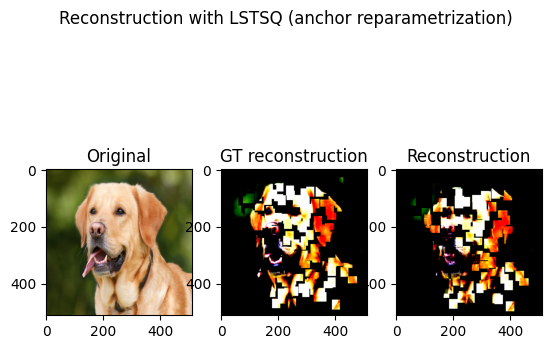

In [ ]:
# from src.utils.visualization.reconstruction_a2 import decoupled_translation_scale_reconstruction_from_crops
# from src.utils.visualization.reconstruction_anchor_reparam import  reconstruction_from_gt_dT_with_anchor
from src.utils.visualization.reconstruction_anchor_reparam_v2 import  reconstruction_lstsq_with_anchor_reparam

batch = next(iter(dataloader))
model.update_conf(mask_ratio=0.75, pos_mask_ratio=0.75)
with torch.no_grad():
    out = model(*batch)

io = clean_model_io(batch, out, 'cuda')

reconstructed_image, pos, scale = reconstruction_lstsq_with_anchor_reparam(
    image_crops=io["img"][0],
    patch_positions=io["patch_positions_nopos"][0],
    gt_dT=io["pred_dT"][0],
    patch_size=16,  # or wherever your patch size is stored
    img_size=224,
    canonical_img_size=512,
    max_scale_ratio=4.0,
    crop_params=io["crop_params"][0],
)

fig, axes = make_plots(reconstructed_image, io, 0, imgs[0])
fig.suptitle("Reconstruction with LSTSQ (anchor reparametrization)")
fig.show()

Text(0, 0.5, 'Log Scale (Width)')

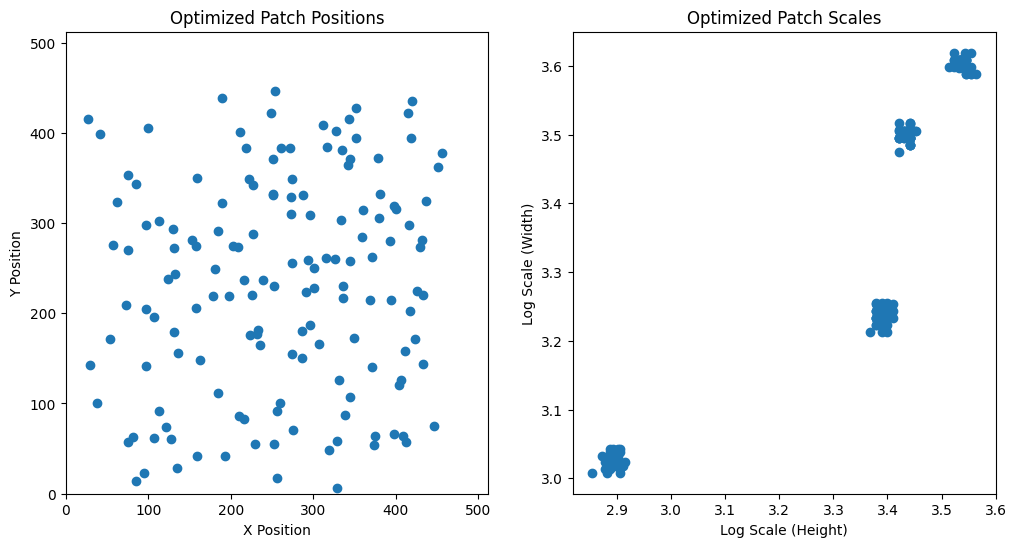

In [50]:
# plot the positions and scales
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
_pos = torch.stack(pos, dim=0)
_scale = torch.stack(scale, dim=0)
# Plot positions
ax[0].scatter(_pos[:, :, 0], _pos[:, :, 1])
# set range to [0, 512] for both axes
ax[0].set_xlim(0, 512)
ax[0].set_ylim(0, 512)
ax[0].set_title("Optimized Patch Positions")
ax[0].set_xlabel("X Position")
ax[0].set_ylabel("Y Position")

# Plot scales
ax[1].scatter((_scale[:, :, 0]), (_scale[:, :, 1]))
ax[1].set_title("Optimized Patch Scales")
ax[1].set_xlabel("Log Scale (Height)")
ax[1].set_ylabel("Log Scale (Width)")
